# <center> CS 178: Machine Learning &amp; Data Mining </center>
## <center> Homework 2: Due Friday 28 April 2023 (11:59 PM)</center>
### <center> Version 1.0 (Last Modified: 18 April 2023) </center>

---
## Instructions

This homework (and many subsequent ones) will involve data analysis and reporting on methods and results
using Python code. You will submit a **single PDF file** that contains everything to Gradescope. This includes any text you wish to include to describe your results, the complete code snippets of how you attempted each problem, any figures that were generated, and scans of any work on paper that you wish to include. It is important that you include enough detail that we know how you solved the problem, since otherwise we will be unable to grade it.


Your homeworks will be given to you as Jupyter notebooks containing the problem descriptions and some template code that will help you get started. You are encouraged to modify these starter Jupyter notebooks to complete your assignment and to write your report. You may add additional cells (containing either code or text) as needed. This will help you not only ensure that all of the code for the solutions is included, but also will provide an easy way to export your results to a PDF file (for example, doing *print preview* and *printing to pdf*). I recommend liberal use of Markdown cells to create headers for each problem and sub-problem, explaining your implementation/answers, and including any mathematical equations. For parts of the homework you do on paper, scan it in such that it is legible (there are a number of free Android/iOS scanning apps, if you do not have access to a scanner), and include it as an image in the Jupyter notebook.

If you have any questions/concerns about using Jupyter notebooks, ask us on EdD. If you decide not to use Jupyter notebooks, but go with Microsoft Word or Latex to create your PDF file, make sure that all of the answers can be generated from the code snippets included in the document.

### Summary of Assignment: 100 total points
- Problem 1: Nearest Centroids on MNIST Dataset (25 points)
    - Problem 1.1: Visualizing MNIST (5 points)
    - Problem 1.2: Implementing Nearest Centroids (10 points)
    - Problem 1.3: Evaluating Nearest Centroids (10 points)
- Problem 2: kNN on Penguins Dataset (20 points)
    - Problem 2.1: Plot decision boundary for various k (10 points)
    - Problem 2.2: Plot tr/te error for various k (10 points)
- Problem 3: Logistic Regression (50 points)
    - Problem 3.1: Implement Forward Pass of Logistic Regression and fit to Penguins Dataset (10 points)
    - Problem 3.2: Explore Yelp dataset (10 points)
    - Problem 3.3: Fit a logistic regression classifier on Yelp dataset. (10 points)
    - Problem 3.4: Find the top k most negative/most positive features and corresponding coefficients. (10 points)
    - Problem 3.5: Tune reguarlization parameter on Yelp dataset (10 points)
- Statement of Collaboration (5 points)

Before we get started, let's import some libraries that you will make use of in this assigment. Make sure that you run the code cell below in order to import these libraries.

**Important: In the code block below, we set `seed=1234`. This is to ensure your code has reproducible results and is important for grading. Do not change this. If you are not using the provided Jupyter notebook, make sure to also set the random seed as below.**

In [1]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed)  

---
## Problem 1: Nearest Centroid on MNIST Dataset 

In this problem, you will implement a nearest centroid classifier and train it on the MNIST dataset. The MNIST dataset is an image dataset consisting of 70,000 hand-written digits (from 0 to 9), each of which is a 28x28 grayscale image. For each image, we also have a label, corresponding to which digit is written. Run the following block of code to load the MNIST dataset:

In [2]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK
# Load the features and labels for the MNIST dataset
# This might take a minute to download the images.
mnist_X, mnist_y = fetch_openml('mnist_784', as_frame=False, return_X_y=True)

#print(mnist_y[:10])
#print(mnist_X[0])

# Convert labels to integer data type
mnist_y = mnist_y.astype(int)

C:\Users\vthai\miniconda3\envs\cs178\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In the following block, we split the MNIST dataset into training and testing sets -- 75% of the data is used for training, and 25% is used for testing. The function `train_test_split` is provided by scikit-learn, and will automatically shuffle our data for us if we use the flag `shuffle=True`. 

**NOTE:** For this homework, do not alter the flag `random_state=seed`, as this is necessary for obtaining reproducible results.

In [3]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK
mnist_X_tr, mnist_X_te, mnist_y_tr, mnist_y_te = train_test_split(mnist_X, mnist_y, 
                                                                  test_size=0.25, random_state=seed, shuffle=True)

###  Problem 1.1 (5 points): MNIST Visualization
Let's begin by visualizing a few of the images in the MNIST dataset.

- Plot the first 9 images in `mnist_X_tr` in a 3x3 grid.
- Include a title for each subplot indicating the label of the image.

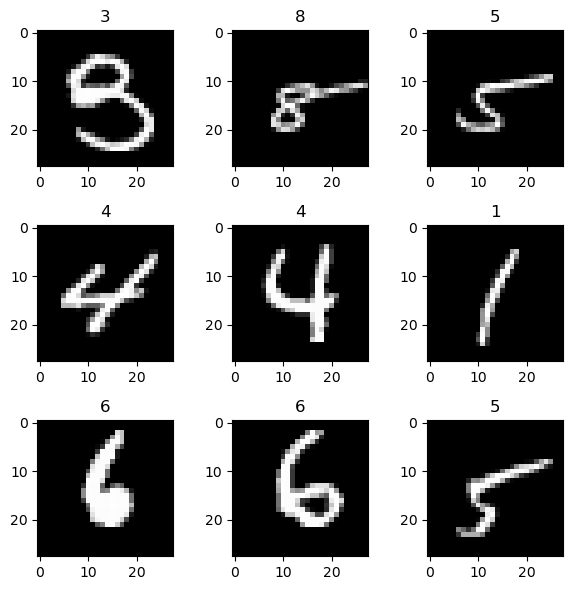

In [4]:
# Some default settings for our plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Create a figure with 3 rows and 3 columns
figure, axes = plt.subplots(3, 3, figsize=(6, 6))  

### YOUR CODE STARTS HERE ###
# Plot the first 9 images in our dataset.
# Include a title on each subplot to indicate the corresponding label.

mnist_X_tr_reshape = np.reshape(mnist_X_tr, (mnist_X_tr.shape[0], -1)) # turn into 2D array
for i in range(0, 9):
    ax = axes[i // 3, i % 3]
    image = mnist_X_tr_reshape[i].reshape(28,28) # recall 28 x 28 pixels
    ax.imshow(image)
    ax.set_title(mnist_y_tr[i])
    
### YOUR CODE ENDS HERE  ###

plt.tight_layout()

### Problem 1.2 (20 points): Implementing a Nearest Centroid Classifier

In the code given below, we define the class `NearestCentroidClassifier` which has an unfinished implementation of a nearest centroid classifier. For this problem, you will complete this implementation.

- Implement the method `fit`, which takes in an array of features `X` and an array of labels `y` and trains our classifier.
- Test your implementation of `fit` by training a `NearestCentroidClassifier` on the MNIST training set, and using the provided method `plot_centroids` to visualize the centroids. If your implementation is correct, the centroids should resemble the corresponding class label in the plot.
- Implement the method `predict`, which takes in an (array of) feature vectors `X` and predicts their class labels.
- Print the predicted labels (using your `predict` function) and the true labels for the first ten images in the MNIST testing set.

In [25]:
class NearestCentroidClassifier:
    def __init__(self):
        # A list containing the centroids; to be filled in with the fit method.
        self.centroids = []  
        
    def plot_centroids(self):
        # Some default settings for our plots
        plt.rcParams['image.interpolation'] = 'nearest'
        plt.rcParams['image.cmap'] = 'gray'

        # Create a figure with 2 rows and 5 columns
        figure, axes = plt.subplots(2, 5, figsize=(12, 4))  
        
        # Plot the centroids
        for i in range(10):
            axes[i//5, i%5].imshow(self.centroids[i].reshape(28, 28))
            axes[i//5, i%5].set_title(f'Label: {i}')
        
        plt.tight_layout()
        plt.show()
        
    def fit(self, X, y):
        """ Fits the nearest centroid classifier with training features X and training labels y.
        X: array of training features; shape (n, d), where n is the number of datapoints,
        and d is the number of features.
        y: array training labels; shape (n, ), where n is the number of datapoints.
        """

        ### YOUR CODE STARTS HERE ###
        # Hint: you should append to self.centroids with the corresponding centroids.
        # Recall from the lecture that we will calculate the means of the features to get our centroid position
        # map the features to the labels
        # the features are the pixels
        
        # add up the pixel values, divide by number of pixels (n)
        
        n = len(y)
        calcList = np.zeros([10, 784]) # rows = centroid, cols = pixels 
        for i in range(0, n): # n is number of data points 
            # numpy.add?
            dataLabel = y[i]
            np.add(X[i], calcList[dataLabel], out=calcList[dataLabel])
        
        for calcCentroid in calcList:
            calcCentroid /= n # average by the amount of data points to get mean
            self.centroids.append(calcCentroid)
            
            
        ### YOUR CODE ENDS HERE
                    
    def predict(self, X):
        """ Makes predictions with the nearest centroid classifier on the features in X.

        X: array of features; shape (n, d), where n is the number of datapoints,
        and d is the number of features.

        Returns:
        y_pred: a numpy array of predicted labels; shape (n, ), where n is the number of datapoints.
        """

        ### YOUR CODE STARTS HERE ###
        
        # Calculate distances to the centroids, predict using the centroid w/ smallest distance
        # Use euclidian distance for each pixel, add up squared distances
        # Refer to slides for more context
        
        # given the data points that have 784 features, return the prediction
        n = np.shape(X)[0] # get number of rows i.e. data points
        y_pred = []
        euclidDistList = np.array([0] * 10)
        for i in range(n):
            for j in range(10):
                euclidDists = (X[i] - self.centroids[j]) ** 2 # array operations
                euclidDistList[j] = np.sum(euclidDists)
            bestLabel = np.argmin(euclidDistList)
            y_pred.append(bestLabel)
        ### YOUR CODE ENDS HERE ###    
        
        return y_pred

In [26]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK
nc_classifier = NearestCentroidClassifier()
nc_classifier.fit(mnist_X_tr, mnist_y_tr)

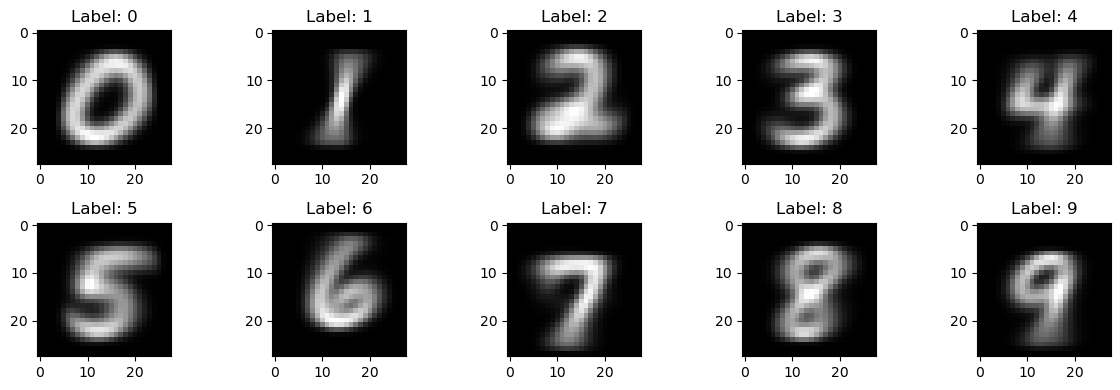

In [27]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK
nc_classifier.plot_centroids()

In [28]:
# Print the predicted and true labels for the first ten images in the MNIST testing set
### YOUR CODE STARTS HERE ###

testPredict = nc_classifier.predict(mnist_X_te)

# predicted labels
print(testPredict[:10])

# true labels
print(mnist_y_te[:10])

### YOUR CODE ENDS HERE ###

[6, 6, 7, 7, 4, 7, 3, 9, 3, 8]
[6 6 7 7 4 7 3 4 3 5]


### Problem 1.3 (10 points): Evaluating the Nearest Centroids Classifier

Now that you've implemented the nearest centroid classifier, it is time to evaluate its performance.

- Write a function `compute_accuracy` that computes the accuracy of a model's predictions. That is, your function should take in an array of true labels y and an array of predicted labels `y_pred`, and return the accuracy of the predictions. You may use numpy to do this, but do not use `sklearn` or any other machine learning libraries.
- Write a function that computes the confusion matrix of a model's predictions. That is, your function should  take in an array of true labels `y`and an array of predicted labels `y_pred`, and return the confusion matrix as a numpy array. You may use numpy to do this, but do not use `sklearn` or any other machine learning libraries.
- Verify that your implementations of `NearestCentroidClassifier`, `compute_accuracy`, and `compute_confusion_matrix` are correct. To help you do this, you are given the functions `eval_sklearn_implementation` and `eval_my_implementation`. The function `eval_sklearn_implementation` will use the relevant `sklearn` implementations to compute the accuracy and confusion matrix of a nearest centroid classifier. The function `eval_my_implementation` will do the same, but for your implementations. If your code is correct, the outputs of the two functions should be the same.

In [ ]:
def compute_accuracy(y, y_pred):
    """ Computes the accuracy of an array of predictions.

    y: true labels; shape (n, ), where n is the number of datapoints.
    y_pred: predicted labels; shape (n, ), where n is the number of datapoints.

    Returns:
    accuracy: the accuracy of y_pred compared to y; scalar expressed as a decimal (e.g. 0.5)
    """
    ### YOUR CODE STARTS HERE ###
    
    
    ### YOUR CODE ENDS HERE ###
    
    return accuracy

In [ ]:
def compute_confusion_matrix(y, y_pred):
    """ Computes the confusion matrix of an array of predictions.

    y: true labels; shape (n, ), where n is the number of datapoints.
    y_pred: predicted labels; shape (n, ), where n is the number of datapoints.

    Returns:
    confusion_matrix: a numpy array corresponding to the confusion matrix from y and y_pred; shape (C, C),
    where C is the number of unique classes.
    """
    ### YOUR CODE STARTS HERE ###
    
        
    ### YOUR CODE ENDS HERE ###
    return conf_matrix
    

Run the two code blocks below to compare your implementation to the implementation in `sklearn`. Make sure you read and understand this code.

In [ ]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK

###############################################
### Results with the sklearn implementation ###
###############################################

def eval_sklearn_implementation(X_tr, y_tr, X_te, y_te):
    # Nearest centroid classifier implemented in sklearn
    sklearn_nearest_centroid = NearestCentroid()

    # Fit on training dataset
    sklearn_nearest_centroid.fit(X_tr, y_tr)

    # Make predictions on training and testing data
    sklearn_y_pred_tr = sklearn_nearest_centroid.predict(X_tr)
    sklearn_y_pred_te = sklearn_nearest_centroid.predict(X_te)

    # Evaluate accuracies using the sklearn function accuracy_score
    sklearn_acc_tr = accuracy_score(y_tr, sklearn_y_pred_tr)
    sklearn_acc_te = accuracy_score(y_te, sklearn_y_pred_te)

    print(f'Sklearn Results:')
    print(f'--- Accuracy (train): {sklearn_acc_tr}')
    print(f'--- Accuracy (test): {sklearn_acc_te}')

    # Evaluate confusion matrix using the sklearn function confusion_matrix
    sklearn_cm = confusion_matrix(y_te, sklearn_y_pred_te)
    sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
    sklearn_disp.plot();
    
    
# Call the function    
eval_sklearn_implementation(mnist_X_tr, mnist_y_tr, mnist_X_te, mnist_y_te)

In [ ]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK

#########################################
### Results with your implementation ###
#########################################

def eval_my_implementation(X_tr, y_tr, X_te, y_te):
    # Now test your implementation of NearestCentroidClassifier
    nearest_centroid = NearestCentroidClassifier()

    # Fit on training dataset
    nearest_centroid.fit(X_tr, y_tr)

    # Make predictions on training and testing data
    y_pred_tr = nearest_centroid.predict(X_tr)
    y_pred_te = nearest_centroid.predict(X_te)

    # Evaluate accuracies using your function compute_accuracy
    acc_tr = compute_accuracy(y_tr, y_pred_tr)
    acc_te = compute_accuracy(y_te, y_pred_te)

    print(f'Your Results:')
    print(f'--- Accuracy (train): {acc_tr}')
    print(f'--- Accuracy (test): {acc_te}')

    # Evaluate confusion matrix using your function compute_confusion_matrix
    cm = compute_confusion_matrix(y_te, y_pred_te)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot();
    

# Call the function
eval_my_implementation(mnist_X_tr, mnist_y_tr, mnist_X_te, mnist_y_te)

---
## Problem 2: kNN on Penguins Dataset

For the final problem of this homework, you will explore the k-nearest-neighbors algorithm using the Penguins dataset.

<font color='red'><b>Important: Be sure to download the `penguins.csv` file from Canvas and place it in the same directory of this notebook.</b></font>

In [ ]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK
# Load the Penguins dataset
peng_data = pd.read_csv("./penguins.csv")  # Note that this is in the form of a Pandas dataframe, not the Numpy array that we have typically seen 
peng_data.head() 

### Problem 2.1: Decision Boundaries (15 points)
- Using the code given in Problem 1 and Problem 2, to create a train/test split of the Penguins dataset only containing the features "bill_length_mm" and "bill_depth_mm", as well as the class label "species". Use 75% of the data for training, and 25% of the data for testing. Set `shuffle=True` and be sure to use `random_state=seed`. Save the train/test split of the input features as `peng_X_tr` and `peng_X_te` respectively. For the train/test split of the class labels, store these under variable names `peng_y_tr` and `peng_y_te` respectively.
- For the values of `k=[1, 5, 10, 50]`, fit a kNN classifier on this new training set with each value for `k` and plot the resulting decision boundary. Your plot should have 4 subplots total, clearly labeled and arranged in 2 rows and 2 columns. Each plot should showcase the decision boundary as well as display the individual training points with the colors of the point corresponding to the class.
- Write a short description of what you see happen as you increase the value of `k`. 

Note that you are intended to use the `sklearn` implementation of kNN for this problem and 2.2.

In [ ]:
# Create a 75%/25% train/test split using only the "bill_length_mm" and "bill_depth_mm" features in the Penguins data, 
# along with the class labels "species".
### YOUR CODE STARTS HERE ###
peng_X_tr, peng_X_te, peng_y_tr, peng_y_te = ...
### YOUR CODE ENDS HERE ###
print(peng_X_tr.shape, peng_X_te.shape, peng_y_tr.shape, peng_y_te.shape)

In [ ]:
# Some keyword arguments for making nice looking plots.
# Feel free to change grid_resolution to a higher number -- this results in better looking plots,
# but may result in your code running more slowly.
plot_kwargs = {'cmap': 'viridis',
               'response_method': 'predict',
               'plot_method': 'pcolormesh',
               'shading': 'auto',
               'alpha': 0.5,
               'grid_resolution': 100}


# Create a figure with 2 rows and 2 columns
figure, axes = plt.subplots(2, 2, figsize=(8, 8))

### YOUR CODE STARTS HERE ###
# Feel free to use the LabelEncoder to convert the class label strings into integer values for plotting purposes


### YOUR CODE ENDS HERE ###

### Problem 2.2: Error Rates vs k  (15 points)

Now, we will vary the value of $k$ and see what effect this has on our predictions.

- Again using only the "bill_length_mm" and "bill_depth_mm" features of the Penguins dataset, compute the error rate on both the training and testing data as a function of `k`. Do this for all values of `k = [1, 2, 5, 10, 50, 100, 110]`. You may use your own implementation of the accuracy, or the scikit-learn function `sklearn.metrics.accuracy_score`.
- Plot the resulting error rate functions using a semi-log plot (i.e. the x-axis is on a logarithmic scale), with the training error in red and the validation error in green. 
- What value of `k` would you recommend, and why?

In [ ]:
# Create a figure with only one subplot
figure, axes = plt.subplots(1, figsize=(6, 6))

### YOUR CODE STARTS HERE ###

### YOUR CODE ENDS HERE ###

---
## Problem 3: Logistic Regression

<font color='red'><b>Important: We will need to install three more libraries for this assignment, do not skip this. Also, be sure to download the `yelp_reviews.json` file from Canvas and place it in the same directory of this notebook</b></font>

We need to run `conda install -c conda-forge scipy simplejson nltk` in order to install `scipy`, `nltk`, and `simplejson`. 

We need `scipy` to work with certain mathematical optimization techniques, `nltk` to work with natural language data, and `simplejson` to open json files.

In this problem, you will first implement a basic version of logistic regression on the Penguins dataset, and then you will work with the sklearn implmentation of logistic regression on a more realistic dataset.

In [ ]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK
from scipy.optimize import minimize
import simplejson as json
import nltk 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
from nltk import word_tokenize

### Problem 3.1 (10 points): Implement Forward Pass of Logistic Regression and fit to Penguins Dataset 

Recall that logistic regression models the probability of a datapoint with features $x_1, x_2$ having class $y=1$ via:
$$p(y=1 | x_1, x_2) = \sigma(\theta_0 + \theta_1x_1 + \theta_2x_2)$$
where $\sigma(z)=\frac{1}{1+e^{-z}}$. Likewise, it models the probability of class $y=0$ via $p(y=0|x_1, x_2)=1-\sigma(\theta_0 + \theta_1x_1 + \theta_2x_2)$. We typically learn parameter values $\theta_0, \theta_1, \theta_2$ by minimizing the cross-entropy of a given dataset:
$$\mathcal{L}(\theta_0, \theta_1, \theta_2; \vec{y}, \vec{x}_1, \vec{x}_2) = \frac{1}{n} \sum_{i=1}^n -y_i \log p(y=1 | x_{i1}, x_{i2}) - (1-y_i)\log p(y=0 | x_{i1}, x_{i2})$$

- Implement the `logistic_prob` function that takes in parameter values `theta_0`, `theta_1`, and `theta_2`, as well as two vectors of input data `x_1` and `x_2` of length $n$, and produces the $n$ corresponding probability values of $y=1|x_1, x_2$ as an `np.array`.
- Implement the `logistic_loss` function that takes in parameter values `theta_0`, `theta_1`, and `theta_2`, as well as three data vectors of input features `x_1` and `x_2` and the class values `y` of length $n$, and produces the cross-entropy value as defined above. Note this should call the `logistic_prob` function.
- Implement the `plot_boundary_with_intercept` function that takes in parameter values `theta_0`, `theta_1`, and `theta_2`, as well as three data vectors of input features `x_1` and `x_2` and the class values `y` of length $n$, and plots all datapoints `x_1` on the x-axis, `x_2` on the y-axis, with colors determined by class values `y`, and the decision boundary determined via parameter values.
- From the Penguins dataset, let `x_1` be the "bill_length_mm" feature, let `x_2` be the "bill_depth_mm" feature, and let `y` be a 1 when a penguin is of the "Adelie" species and a 0 when not. Use `scipy`'s `minimize` function to find the optimal parameter values $\theta_0, \theta_1, \theta_2$ that minimize the negative cross-entropy over this dataset. Plot the resulting decision boundary using `plot_boundary_with_intercept` (note this can be done exactly since the model is simple).

In [ ]:
def sigmoid(z):
    if isinstance(z, np.ndarray):
        return 1 / (1 + np.exp(-z))
    else:
        return 1 / (1 + math.exp(-z))

def logistic_prob(theta_0, theta_1, theta_2, x_1, x_2):
    '''Return probability of y=1 given x_1 and x_2 for specific parameter values theta_0,
    theta_1, and theta_2.'''
    ### YOUR CODE STARTS HERE ###

    ### YOUR CODE ENDS HERE ###
    return prob_y1

In [ ]:
def logistic_loss(theta_0, theta_1, theta_2, x_1, x_2, y):
    '''Compute the cross-entropy for logistic regression model parameterized by 
    theta_0, theta_1, and theta_2 over dataset y | x_1, x_2.'''
    ### YOUR CODE STARTS HERE ###


    ### YOUR CODE ENDS HERE ###
    return cross_entropy

In [ ]:
def plot_boundary_w_intercept(theta_0, theta_1, theta_2, x_1, x_2, y): 
    '''
    theta_0: the bias of linear model
    theta_1: the first parameter of linear model
    theta_2: the second parameter of linear model
    x_1:       [# feature vectors], feature vectors
    x_2:       [# feature vectors], feature vectors
    y:       [# feature vectors], labels
    '''
    
    # Make a figure with 1 subplot
    fig, axes = plt.subplots()

    ### YOUR CODE STARTS HERE ###
    

    
    ### YOUR CODE ENDS HERE ###

In [ ]:
# Set `x_1` and `x_2` to be the training values for the "bill_length_mm" and "bill_depth_mm" features.
# Set `y` to be an array with values of 1 if the training observation is of species "Adelie" and 0 otherwise. 
# `y` should be of same length as `x_1` and `x_2`.
### YOUR CODE STARTS HERE ###
x_1 = ...
x_2 = ...

y = ...
### YOUR CODE ENDS HERE ###
print(x_1.shape, x_2.shape, y.shape)

In [ ]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK

# Standardize inputs
std_x_1 = (x_1-x_1.mean()) / x_1.std()
std_x_2 = (x_2-x_2.mean()) / x_2.std()

loss_function = lambda thetas: logistic_loss(thetas[0], thetas[1], thetas[2], x_1=std_x_1, x_2=std_x_2, y=y)
bound = 20  # Limit search of theta values to have this magnitude or less for stability reasons 
initial_parameter_value = np.array([0.0, 0.0, 0.0])
r = minimize(loss_function, initial_parameter_value, bounds=[(-bound, bound) for _ in range(3)])
print("theta_0={}, theta_1={}, theta_2={}".format(*r.x))
plot_boundary_w_intercept(theta_0=r.x[0], theta_1=r.x[1],  theta_2=r.x[2], x_1=std_x_1, x_2=std_x_2, y=y)

### Problem 3.2 (10 points): Explore Yelp dataset

The Yelp dataset can be used in a sentiment analysis task, where we are given a review and we predict whether it's positive or negative. We will pre-process the dataset for you with bag-of-words approach. You will create a bag of words (BOW) representation from text documents, using the Vectorizer function in scikit-learn. 

A bag of words representation of text is a way to turn text into a fixed size vectorized output, this is done by deciding on a fixed-size vocabulary of words that are often used and then assigning each word a number, then, every sentence in a dataset is turned into a vector $\mathbf{x}$, where $\mathbf{x}_i$ denotes whether the $i$th word in our list is used in the sentence. For example, if our vocabulary is `[he, she, his, her, loves, likes, dogs, cats, cute, nice]`, the sentence `"he loves cat and she loves dog"` can be vectorized as `[1, 1, 0, 0, 2, 0, 1, 1, 0, 0]`. This representation allows us to compare sentences in the same way we have been doing to tabular data and images.

The inputs are 
- a filename (you will use "yelp_reviews.json") containing the reviews in JSON format 
- the min_pos and max_neg parameters (use the default values.)

The outputs are
- **X**: Feature Matrix in compressed sparse row format.
    - $\textbf{X}$ is in shape of [# reviews, # terms in vocabulary]
    - $\textbf{X}_{ij}$ indicates the number of the $j$th term in the vocabulary existing in the $i$th review.
- **y**: Review label vector
- **text**: Raw reviews
- **vectorizer_BOW.vocabulary_**: A mapping of terms to feature indices, somes terms are excluded



**NOTE**: 
- please read the scikit-learn tutorial on text feature extraction before you start this problem: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

In [ ]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK
def create_bow_from_reviews(filename, min_pos=4, max_neg=2): 
    
    print('Loading the file:', filename) 
    with open(filename, 'r') as jfile:
        data = json.load(jfile)
        
    print('Total number of reviews extracted =', len(data))

    text = []
    y = []
    print('Extracting tokens from each review.....(can be slow for a large number of reviews)......')   
    for d in data: 	# can substitute data[0:9] here if you want to test this function on just a few reviews 	
        review = d['text']     # keep only the text and label
        stars = int(d['stars'])
        if stars >= min_pos:   # represent scores > min_pos as "1"
            score = 1
        elif stars <= max_neg:  # represent scores < max_neg as "0"
            score = 0
        else: # do not consider reviews with scores above max_neg and below min_pos (these reviews will be dropped)
            continue  
 
        text.append(review)   
        y.append(score)
    
    # create an instance of a CountVectorizer, using 
    # (1) the standard 'english' stopword set 
    # (2) only keeping terms in the vocabulary that occur in at least 1% of documents
    # (3) allowing only unigrams in the vocabulary (use "ngram_range=(1, 1)" to do this)
    vectorizer = CountVectorizer(stop_words='english',min_df=0.02, ngram_range=(1, 1))

    # create a sparse BOW array from 'text' using vectorizer
    X = vectorizer.fit_transform(text)
 
    print('Data shape: ', X.shape)
    
    # you can uncomment this next line if you want to see the full list of tokens in the vocabulary  
    #print('Vocabulary: ', vectorizer.get_feature_names())
 
    return X, y, vectorizer, text

In [ ]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK
X, y, vectorizer_BOW, text = create_bow_from_reviews('yelp_reviews.json') 

Implement the function `review_word_count_histogram` , which generates a histogram to show how many unique words (from the vocabulary) are in each review. That is, for each review, count the number of unique words in the review, and plot a histogram illustrating these counts.

In [ ]:
def review_word_count_histgram(X):
    ### YOUR CODE STARTS HERE ###
    
    ... .
    ### YOUR CODE ENDS HERE ###

review_word_count_histgram(X)

### Problem 3.3 (10 points): Fit a logistic regression classifier on Yelp dataset.

Separate an X,Y dataset (X=features, Y=labels) into training and test subsets
- Build a logistic classifier (from `sklearn`, not our previous implementation from problem 3.1) on the training subset. **Please use 'l1' `penality` type, 'liblinear' `solver` and enable `fit_intercept`**
- Evaluate performance on the test subset

**NOTE**: 
before starting this problem please read the scikit-learn documentation on logistic classifiers: https://scikit-learn.org/stable/modules/linear_model.html and logistic regression https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

In [ ]:
def logistic_classification(X, y): 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    #  set the state of the random number generator so that we get the same results across runs when testing our code
     
    print('Number of training examples: ', X_train.shape[0])
    print('Number of testing examples: ', X_test.shape[0])   
    print('Vocabulary size: ', X_train.shape[1]) 
 
    ### YOUR CODE STARTS HERE ###
    # Specify the logistic classifier model
    # Please use 'l1' penality type, 'liblinear' solver and enable fit_intercept
    classifier = ...

    
    # Compute and print accuracy on the test data
    test_predictions = ...
    test_accuracy = ... 

    ### YOUR CODE ENDS HERE ###
    
    print('\nTesting accuracy:', format( 100*test_accuracy , '.2f') )

    return classifier

In [ ]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK
logistic_classifier = logistic_classification(X, y)

### Problem 3.4 (10 points): Find the top k most negative/most positive features

In this problem, you will complete the function `most_significant_terms` to 
- print out and return the most significant positive and negative weights 
- print our the associated terms

`most_significant_terms` takes as input
- a scikit-learn trained logistic regression classifier (e.g., trained in Problem 2.3) 
- a scikit-learn vectorizer object that produced the BOW features for the classifier

and prints out
- the terms in the vocabulary tokens with the **top10** largest positive weights  
- the terms in the vocabulary with the **top10** smallest (i.e., largest in terms of absolute value) negative weights

Hint: Check the attributes section of the vectorizer documentation (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to find where the mapping between words and indices are located.

In [ ]:
def most_significant_terms(classifier, vectorizer, K):
    # cycle through the positive weights, in the order of largest weight first and print out
    # K lines where each line contains
    # (a) the term corresponding to the weight (a string)
    # (b) the weight value itself (a scalar printed to 3 decimal places)

    ### YOUR CODE STARTS HERE ###

    # extract coefficients from trained model and sort based on coefficient
    ...

    # extract topK positive terms
    topK_pos_terms = ...

    # extract corresponding weights
    topK_pos_weights = ...

    # extract topK negative terms
    topK_neg_terms = ...

    # extract corresponding weights
    topK_neg_weights = ...
    
    ### YOUR CODE ENDS HERE ###
    print('topK_pos_weights', topK_pos_weights)
    print('topK_pos_terms', topK_pos_terms)
    print('topK_neg_weights', topK_neg_weights)
    print('topK_neg_terms',topK_neg_terms)
    return (topK_pos_weights, topK_neg_weights, topK_pos_terms, topK_neg_terms)

In [ ]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK
output = most_significant_terms(logistic_classifier, vectorizer_BOW, K=10)

### Problem 3.5 (10 points): Tune reguarlization parameter on Yelp dataset

In this problem, you will complete the function `accuracy_vs_reg`
- plot curve of train/test accuracy vs regularization strength.
- choose a final value for the regularization parameter and explain why.

In [ ]:
def accuracy_vs_reg(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    #  set the state of the random number generator so that we get the same results across runs when testing our code
    
    coefs_ = []
    train_accuracies = []
    test_accuracies = []
    cs = [0, 0.1, 1, 10, 50]

    ### YOUR CODE STARTS HERE ###
    for c in cs:
        
        # Specify the logistic classifier modle
        if c == 0:
            classifier = LogisticRegression(penalty='none', fit_intercept=True)
        else:
            # Refer https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression
            # to see which argument can adjust the regularization strength,
            # Additionally, please use 'l1' penalty type, 'liblinear' solver and enable fit_intercept
            classifier = ...

        ...

        # log model coefficients
        coefs_.append(...)
        
        # log model training and test accuracies
        train_accuracies.append(...)
        test_accuracies.append(...)

    ### YOUR CODE ENDS HERE ###
    
    fig, axes = plt.subplots()
    axes.semilogx(cs, train_accuracies, color='red', label='training accuracy')
    axes.semilogx(cs, test_accuracies, color='blue', label='testing accuracy')
    
    axes.set_xlabel('regulaization strength', fontsize=14)
    axes.set_ylabel('accuracy', fontsize=14)
    
    axes.legend()

    return train_accuracies, test_accuracies, coefs_

In [ ]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK
train_accuracies, test_accuracies, coefs = accuracy_vs_reg(X, y)

Choose a final value for the regularization parameter and justify your choice. You should choose a single value from the list cs
given in the code above.

---
### Statement of Collaboration (5 points)

It is **mandatory** to include a Statement of Collaboration in each submission, with respect to the guidelines below. Include the names of everyone involved in the discussions (especially in-person ones), and what was discussed.

All students are required to follow the academic honesty guidelines posted on the course website. For
programming assignments, in particular, I encourage the students to organize (perhaps using EdD) to
discuss the task descriptions, requirements, bugs in my code, and the relevant technical content before they start
working on it. However, you should not discuss the specific solutions, and, as a guiding principle, you are not
allowed to take anything written or drawn away from these discussions (i.e. no photographs of the blackboard,
written notes, referring to EdD, etc.). Especially after you have started working on the assignment, try
to restrict the discussion to EdD as much as possible, so that there is no doubt as to the extent of your
collaboration.